# Working with Structures

Add path if package is not installed

In [1]:
import sys
sys.path.append('..')

The prisms seen in the quick start are members of `tnsgrt.structure.Structure`. In fact,
`tnsgrt.prism.Prism` overloads only the constructor of `tnsgrt.structure.Structure`, which provides most
of the functionality.

## Construction

Objects of class `tnsgrt.structure.Structure` are composed of *nodes* and *members*. Nodes are `3 x n` numpy arrays

In [2]:
import numpy as np
nodes = np.array([[0,0,0],[0,1,0],[1,1,0],[1,0,0]]).transpose()

Members are *bars* or *strings*, which are specified by a `2 x m` array with the indices of the nodes that define the
members, as in:

In [3]:
members = np.array([[0,1],[1,2],[2,3],[3,0],[0,2],[1,3]]).transpose()

Nodes and members are then combined to build a `tnsgrt.structure.Structure`:

In [4]:
from tnsgrt.structure import Structure
s = Structure(nodes, members, number_of_strings=4)

The parameter `number_of_strings = 4` means that the first four members are to be considered *strings*.

As before, the resulting structure can be plotted using `tnsgrt.plotter.MatplotlibPlotter`

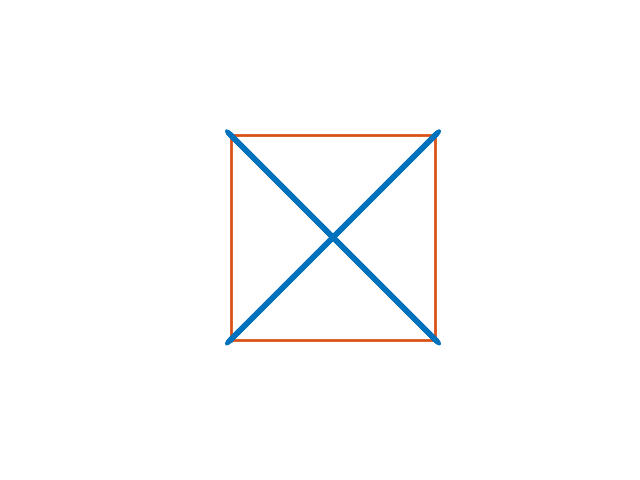

In [5]:
from matplotlib import pyplot as plt
from tnsgrt.plotter.matplotlib import MatplotlibPlotter
%matplotlib widget

plotter = MatplotlibPlotter()
plotter.plot(s)
fig, ax = plotter.get_handles()
ax.view_init(90,-90)
ax.axis('off')
plt.show()

to visualize the resulting planar tensegrity structure built above.

## Equilibrium

Once a structure is built, one can perform various calculations. For example one can determine the member forces so that the structure is in equilibrium in various cases.

### Unloaded

For example:

In [6]:
s.equilibrium()

calculates the forces in the members that maintain the structure in equilibrium.

In this *unloaded* case, no external forces are applied to the structure, and equilibrium is achieved by *pretensioning* the structure. The result of `tnsgrt.structure.Structure.equilibrium` is a set of *force coefficients*, that is forces divided by member length. The result of the equilibrium calculation can be found in the member properties `lambda_` (force coefficient) and `force`:

In [7]:
s.member_properties[['lambda_', 'force']]

,lambda_,force
0,1.0,1.000000
1,1.0,1.000000
2,1.0,1.000000
3,1.0,1.000000
4,-1.0,-1.414214
5,-1.0,-1.414214


Pretension is set so that the average force coefficient on all bars is equal to the parameter `lambda_bar`, which is by default equal to one.

### Loaded

In this case an equilibrium is sought in the presence of external forces, given as a `3 x n` array as the following one:

In [8]:
f = 0.125*np.array([[0,1,0],[0,-1,0],[0,-2,0],[0,2,0]]).transpose()

Each column is a force vector to be applied on the corresponding node.

The external force array `f` can then be passed on to the method equilibrium:

In [9]:
s.equilibrium(f)

resulting in the new set of member forces and force coefficients:

In [10]:
s.member_properties[['lambda_', 'force']]

,lambda_,force
0,1.250000e-01,1.250000e-01
1,2.500000e-01,2.500000e-01
2,-3.758633e-11,-3.758633e-11
3,2.500000e-01,2.500000e-01
4,-2.500000e-01,-3.535534e-01
5,-2.500000e-01,-3.535534e-01


The following visualizes the applied forces superimposed on the structure:

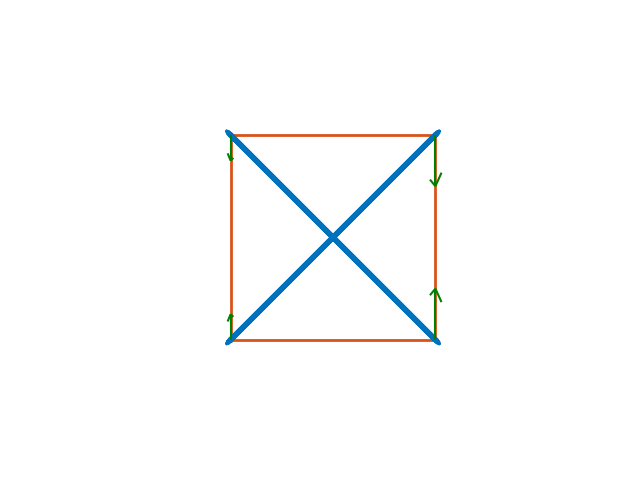

In [11]:
plotter = MatplotlibPlotter()
plotter.plot(s)
fig, ax = plotter.get_handles()
ax.quiver(s.nodes[0,:], s.nodes[1,:], s.nodes[2,:], f[0,:], f[1,:], f[2,:], arrow_length_ratio=0.2, color='g')
ax.view_init(90,-90)
ax.axis('off')
plt.show()

The forces are represented by the green arrows.

When it is not possible to find a set of internal forces that satisfy the equilibrium conditions an Exception with a message "could not find equilibrium" is produced. For example::

In [12]:
f = 0.125*np.array([[0,1,0],[0,-1,0],[0,-1,0],[0,2,0]]).transpose()
s.equilibrium(f)

Exception: could not find equilibrium

can not be made in equilibrium only by internal forces.

## Stiffness

Once a structure is in equilibrium, its response to forces can be calculated in terms of its *stiffness matrix*. For that it is necessary to characterize the members' geometry and material properties. The fundamental properties are the member radius, and elasticity modulus:

In [ ]:
s.member_properties[['radius', 'inner_radius', 'modulus']]

For calculating the stiffness matrix of a pretensioned structure, it also necessary to know the member's force coefficient and the derived member stiffness property. As seen before, the force coefficient and the force are obtained during the equilibrium calculation:

In [ ]:
s.equilibrium()
s.member_properties[['lambda_', 'force', 'stiffness']]

Because the stiffness is a "derived" property, it does not get automatically populated, which can be done by calling `tnsgrt.structure.Structure.update_member_properties`:

In [ ]:
s.update_member_properties('stiffness')
s.member_properties[['stiffness']]

After setting the material properties, one can calculate the stiffness model associated with the current equilibrium:

In [ ]:
stiffness, _, _ = s.stiffness()

For large models, the stiffness is stored and calculated as sparse arrays. However, for small models, such as this one, the model is stored in dense arrays. The warning message can be suppressed by explicitly setting the parameter ``storage=dense``:

In [ ]:
stiffness, _, _ = s.stiffness(storage='dense')

**WARNING:** setting ``storage='dense'`` for large models is not advised.

The stiffness model can be used to calculate various quantities of interest. One example is the calculation of the approximate displacements generated in response to a set of nodal forces. For the nodal forces:

In [ ]:
f = 0.125*np.array([[0,1,0],[0,-1,0],[0,-2,0],[0,2,0]]).transpose()

these approximate displacements can be, in principle, calculated using:

In [ ]:
stiffness.displacements(f)

The failure of the above procedure is due to the singularity of the current stiffness model. This can be visualized by calculating the model's eigenvalues and eigenvectors:

In [ ]:
d, v = stiffness.eigs()

In this case, because there are not enough constraints in the possible nodal displacements of the structure, we encounter various eigenvalues which are numerically close to zero:

In [ ]:
d

Six of these are the so-called "rigid body modes", associated to the three rigid translations and three rigid rotations of the structure. They can be "removed" by applying certain constraints to the set of allowed displacements. Enforcement of these constraints can be done by passing the parameter ``apply_rigid_body_constraint=True`` when calculating the stiffness model:

In [ ]:
stiffness, _, _ = s.stiffness(storage='dense', apply_rigid_body_constraint=True)

To see that the six near zero eigenvalues of the stiffness matrix have been removed by the rigid body constraints
recalculate:

In [ ]:
d, v = stiffness.eigs()
d

Interestingly, in this case, there still remains one eigenvalue that is much smaller than the remaining ones. We will deal with this eigenvalue later.

For now, even though the smallest eigenvalue is small, the resulting stiffness matrix is not singular, and therefore suitable for computing displacements. This times:

In [ ]:
x = stiffness.displacements(f)
x

successfully calculates the resulting approximate displacements, which can be visualized, after much enlargement, along with the applied forces in the figure

In [ ]:
X = f
Y = 5e7*x

plotter = MatplotlibPlotter()
plotter.plot(s)
fig, ax = plotter.get_handles()
ax.quiver(s.nodes[0,:], s.nodes[1,:], s.nodes[2,:], X[0,:], X[1,:], X[2,:], arrow_length_ratio=.2, color='g')
ax.quiver(s.nodes[0,:], s.nodes[1,:], s.nodes[2,:], Y[0,:], Y[1,:], Y[2,:], arrow_length_ratio=.2, color='y')
ax.view_init(90,-90)
ax.axis('off')
plt.show()

The forces are in green and the vectors indicating the resulting displacement are in yellow.

Back to the small eigenvalue, which is sometimes associated with what is called a *soft mode*, results from the fact that the structure is planar, and its ball joints offer little resistance to out-of-plane forces. Indeed, the eigenvector associated with the eigenvalue is:

In [ ]:
v[:,0].reshape((3, 4), order='F')

which constitutes a pair of "couples" in the out-of-plane z-direction.

As with rigid body modes, constraining the node displacements to be planar "eliminates" such mode, as in:

In [ ]:
stiffness, _, _ = s.stiffness(storage='dense', apply_rigid_body_constraint=True, apply_planar_constraint=True)

resulting in a structure in which

In [ ]:
d, v = stiffness.eigs()
d

indicating that there are no soft modes.

Of course one should expect no impact in the displacements if the forces do not have out-of-plane components and

In [ ]:
x = stiffness.displacements(f)
x

indeed returns displacements that are very similar to the ones calculated before.